Import Python libraries

In [ ]:
# To use arrays and optimization
import numpy as np
from scipy.optimize import root
from scipy import integrate

# To manage data
import pandas as pd

# To plot
from pylab import *
from matplotlib.ticker import FormatStrFormatter, AutoMinorLocator
!pip install matplotlib-label-lines
from labellines import labelLine, labelLines
from matplotlib.lines import Line2D

# Other
import copy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create particle flow suspensions solver as a Class object

In [ ]:
class particle_solve:
  def __init__(
      self,
      radius, # radius of the circular tube in m
      alpha, # K_c/K_Eta, model parameter
      dpdz, # pressure gradient in Pa/m
      phi_avg, # average particle volume fraction used in the model
      power_law=False, # True, if we visc model is Power-Law
      sep=False, # True, if the viscosity function is separable
      yieldStress=False, # True, if we use yield-stress based models
      options = {
          'visc_func': None, # viscosity function of phi and s (dimensionless gamma dot)
          'eta_r': None, # viscosity function of phi
          'eta_s': None, # viscosity function of s (dimensionless gamma dot)
      }
  ):
    self.R, self.alpha, self.dpdz, self.avg_phi, self.sep, self.power_law, self.yieldStress = radius, alpha, dpdz, phi_avg, sep, power_law, yieldStress

    if power_law:
        self.phi_m, self.n = options['phi_m'], options['n']

    if self.sep:
        def visc_func(s, phi, gamma_dot_w):
            return options['eta_r'](phi)*options['eta_s'](s, gamma_dot_w)
        self.visc_func = visc_func
        self.eta_r, self.eta_s = options['eta_r'], options['eta_s']
    else:
        self.visc_func = options['visc_func']

        self.yieldStress = yieldStress

        # The default boolean parameter of "power_law" is False. If True, we create new variables "phi_m" amd "n".
        # These were also defined in "visc_func", but since the numerical approach is different for power_law model, we need to define these parameters outside of the function.
  """
  Define the methods
  """
  def eta_w(self, sr_w, phi_w):  #viscosity function at the wall
      return self.visc_func(1, phi_w, sr_w)

  def nond_visc(self, s, phi, sr_w, phi_w): #nondimensiolized viscosity function
      return self.visc_func(s, phi, sr_w)/self.eta_w(sr_w, phi_w)

  def find_sr_w(self, sr_w, phi_w):  #residual function to find the shear rate at the wall by root finding method
      return self.eta_w(sr_w, phi_w)*sr_w - self.dpdz/2*self.R

  def solve_sr_w(self, phi_w): # find the root of the resiudal equation to get the wall shear rate

      sr_w_guess = 0.1

      sol_sr_w = root(lambda sr_w: self.find_sr_w(sr_w, phi_w), [sr_w_guess], method = 'lm').x[0]

      return sol_sr_w

  def solve(self, N, phi_w): #solve for phi and r (phi and s if power law) given wall particle volume fraction (phi_w)

      self.sr_w = self.solve_sr_w(phi_w)

      if self.power_law: # solve for s and phi (instead of r and phi)
          r_vector = np.concatenate((np.linspace(0, 0.01, N), np.linspace(0.011, 1, N))) # this is the trick: we create 100 bins between 0 and 0.001 and another 1000 between 0.0011 and 1;
          s_vector = np.zeros(2*N)
          s_vector[-1] = 1
      else:
          s_vector = np.concatenate((np.linspace(0, 0.001, N), np.linspace(0.0011, 1, N))) # if not power law used, this trick is applied to the array "s" (nond shear rate)
          r_vector = np.linspace(0,1, 2*N)

      N = 2*N

      if self.power_law:
          phi_vector = np.linspace(self.phi_m, phi_w, N)
      else:
          phi_vector = np.ones(N)*self.avg_phi

      result_vector = np.zeros(2)

      j = N-2

      while j > 0:
          def equation(phi):

              if self.power_law:
                  s1 = r_vector[j]**(1/(1-self.alpha))*(phi/phi_w)**(self.alpha/(1-self.alpha))
                  s2 = r_vector[j]**(1/self.n)*((self.phi_m-phi)/(self.phi_m-phi_w))**(1.82/self.n)

                  return s1-s2


              else:
                  r1 = s_vector[j]**(1-self.alpha)*phi_w**self.alpha/(phi**self.alpha)
                  r2 = self.nond_visc(s_vector[j], phi, self.sr_w, phi_w)*s_vector[j]

                  return r1-r2

          result_vector[1] = root(lambda phi: equation(phi), [phi_vector[j+1]], method = 'lm').x[0] #root finding using "lm" method (Levenberg-Marquardt). This finds phi.

          if self.power_law:
              result_vector[0] = r_vector[j]**(1/(1-self.alpha))*(result_vector[1]/phi_w)**(self.alpha/(1-self.alpha)) # Here we use that phi value above to find the value of "r" by back-substituting to one of the equations.
              s_vector[j] = result_vector[0]

          else:
              result_vector[0] = s_vector[j]**(1-self.alpha)*phi_w**self.alpha/(result_vector[1]**self.alpha)
              r_vector[j] = result_vector[0]

          phi_vector[j] = result_vector[1]

          j -= 1

      self.r_sol = r_vector
      self.phi_sol = phi_vector
      self.s = s_vector

      return self.r_sol, self.phi_sol, self.s, self.sr_w

  def solver(self, N):

      interval = np.zeros(2)
      interval[1] = self.avg_phi*1.7

      tol = 1E-8

      err = 1

      i = 0

      while err >= tol:
          mid = (interval[0] + interval[1])/2

          r, phi, s, srw = self.solve(N, mid)

          est_avg_phi = integrate.simpson(np.multiply(phi, r), r, even = "avg")*2

          err = abs(self.avg_phi - est_avg_phi)
          # print(err, est_avg_phi, self.avg_phi)
          i += 1

          M = 500
          if i > M:
              print(f'Maximum iterations of {M} has been reached.')
              break
          elif err < tol:
              u = np.zeros(len(s))

              for i in range(len(r)):
                  u[i] = integrate.simpson(s[i:], r[i:], even = "avg")

              u_avg = integrate.simpson(np.multiply(u, r), r, even = "avg")*2

              # generate: radius, particle volume fraction, nond shear rate, nond velocity, nond avg velocity, wall shear rate, wall particle volume fraction
              # here each data is extracted depending on their variable name. For instance: .r: radius; .phi: phi values; .s: s values; .u: nondimensional velocity; .u_avg: nondimensional average velocity;
              # .srw: wall shear rate; .phi: wall particle volume fraction; .R: maximum radius; etc.
              self.r, self.phi, self.s, self.u, self.u_avg, self.srw, self.phiw = r, phi, s, u, u_avg, srw, mid

          else:
              if est_avg_phi > self.avg_phi:
                  interval[1] = mid
              else:
                  interval[0] = mid

Papanastasious model

In [ ]:
m_values = [1E-2, 1, 1E1, 4E1, 7E1, 1E2, 1E3]
diff_r = []
diff_phi = []
diff_u = []
diff_s = []
diff_srw = []

def KD(phi): #Krieger-Dougherty model
    phi_m = 0.68
    return (1-phi/phi_m)**(-1.82)

def Papanastasious(s, gamma_dot_w): ### define Bingham-Papanastasious model.
  mu_p = 30
  tau_0 = 70
  return mu_p+tau_0/(s*gamma_dot_w)*(1-np.exp(-m*(s*gamma_dot_w)))

options = {
           'eta_s': Papanastasious,
           'eta_r': KD
          }

for m in m_values:

  model = particle_solve(radius=60/1000, alpha = 0.4/0.6, dpdz = 0.25E6, phi_avg = 0.3, power_law=False, sep=True, yieldStress=True, options = options)

  # choose the number of bins
  N = 1000

  # run the solver
  model.solver(N)
  r = model.r
  diff_r.append(r)

  phi = model.phi
  diff_phi.append(phi)

  u = model.u
  diff_u.append(u)

  s = model.s
  diff_s.append(s)

  srw = model.sr_w
  diff_srw.append(srw)

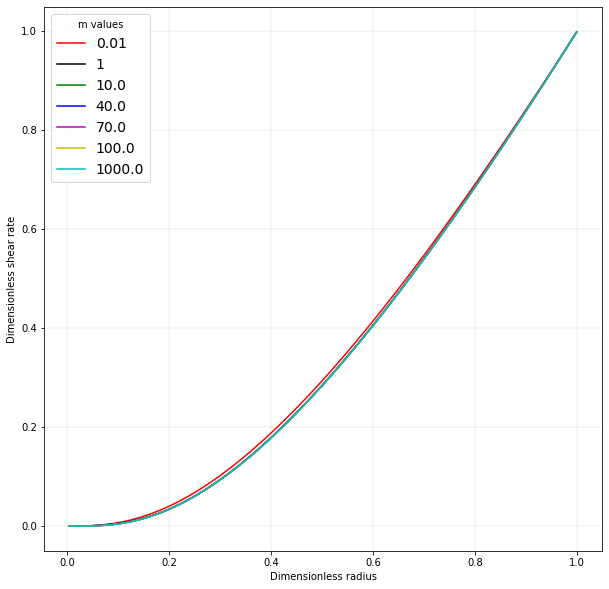

In [ ]:
fig = figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.grid(visible=True, which='both', axis='both', color='g', linestyle='-', linewidth=0.1)

colors = ['r', 'k', 'g', 'b', 'm', 'y', 'c']
for i in range(len(m_values)):
  ax.plot(diff_r[i][1:-1], diff_s[i][1:-1], '-', markevery=20, color=colors[i], label=f"{m_values[i]}")
ax.set_xlabel('Dimensionless radius')
ax.set_ylabel('Dimensionless shear rate')
ax.legend(loc='best', title='m values', prop={'size':14})
show()

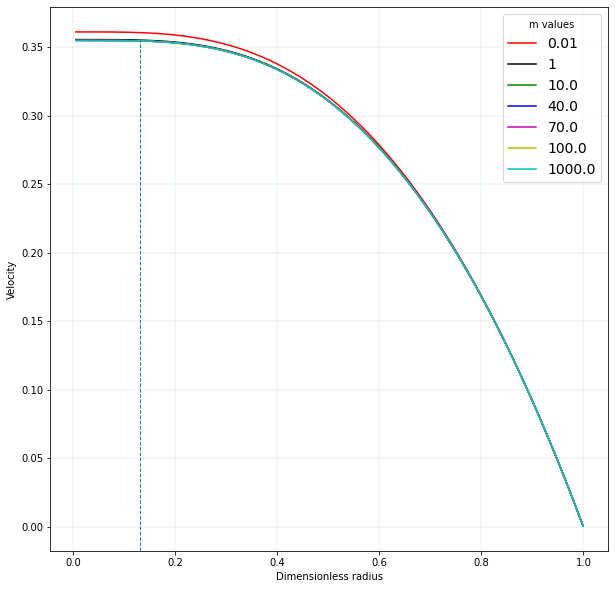

In [ ]:
fig = figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.grid(visible=True, which='both', axis='both', color='g', linestyle='-', linewidth=0.1)

colors = ['r', 'k', 'g', 'b', 'm', 'y', 'c']
for i in range(len(m_values)):
  ax.plot(diff_r[i][1:-1], diff_u[i][1:-1], '-', markevery=20, color=colors[i], label=f"{m_values[i]}")
ax.axvline(x=diff_r[-1][1009], linewidth=1, linestyle="--", ymax=0.94)
ax.set_xlabel('Dimensionless radius')
ax.set_ylabel('Velocity')
ax.legend(loc='best', title='m values', prop={'size':14})
show()

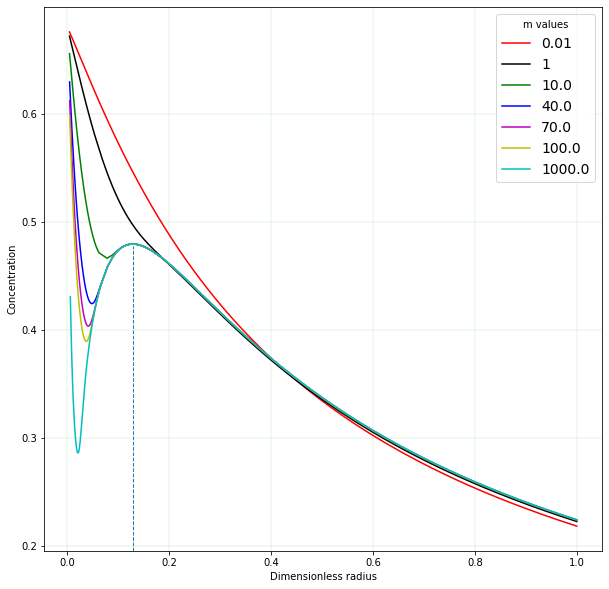

In [ ]:
fig = figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.grid(visible=True, which='both', axis='both', color='g', linestyle='-', linewidth=0.1)
colors = ['r', 'k', 'g', 'b', 'm', 'y', 'c']
for i in range(len(m_values)):
  ax.plot(diff_r[i][1:-1], diff_phi[i][1:-1], '-', markevery=20, color=colors[i], label=f"{m_values[i]}")
ax.axvline(x=diff_r[-1][1009], linewidth=1, linestyle="--", ymax=0.56)
ax.set_xlabel('Dimensionless radius')
ax.set_ylabel('Concentration')
ax.legend(loc='best', title='m values', prop={'size':14})
show()

2020 Fataei paper

In [ ]:
phi_avg_values = [2.35E-2, 10.35E-2, 15.33E-2, 18.97E-2]
diff_r = []
diff_phi = []
diff_u = []
diff_s = []
diff_srw = []

def Fataei(s, phi, gamma_dot_w):
  mu_0 = 130
  tau_0 = 6
  phi_c = 0.719
  m_mu = 0.5
  m_tau = 1
  return mu_0*(1-phi/phi_c)**(-m_mu)+(tau_0*np.sqrt((1-phi)/((1-phi/phi_c)**(m_tau))))/abs(s*gamma_dot_w)

options = {
           'visc_func': Fataei
          }

for phi_avg in phi_avg_values:

  model = particle_solve(radius=125/2000, alpha = 0.4/0.6, dpdz = 27714, phi_avg = phi_avg, power_law=False, sep=False, yieldStress=True, options = options)

  # choose the number of bins
  N = 1000

  # run the solver
  model.solver(N)
  r = model.r
  diff_r.append(r)

  phi = model.phi
  diff_phi.append(phi)

  u = model.u
  diff_u.append(u)

  s = model.s
  diff_s.append(s)

  srw = model.sr_w
  diff_srw.append(srw)

<ipython-input-2-d833cc054ec1>:88: RuntimeWarning: invalid value encountered in power
  r1 = s_vector[j]**(1-self.alpha)*phi_w**self.alpha/(phi**self.alpha)


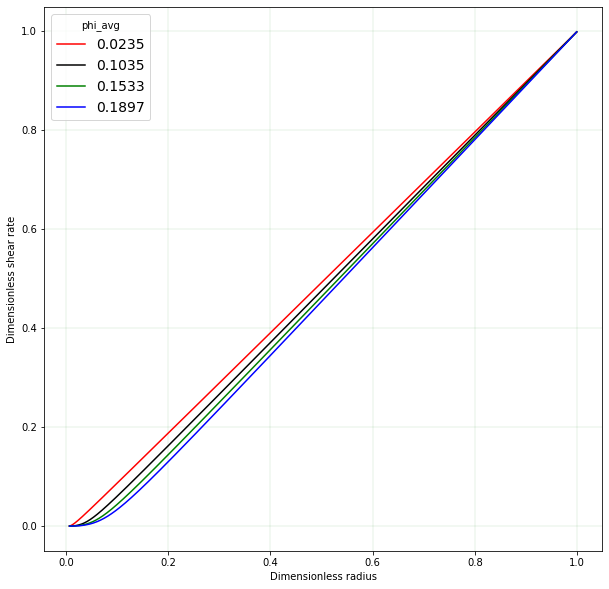

In [ ]:
fig = figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.grid(visible=True, which='both', axis='both', color='g', linestyle='-', linewidth=0.1)

colors = ['r', 'k', 'g', 'b', 'm', 'y', 'c']
for i in range(len(phi_avg_values)):
  ax.plot(diff_r[i][1:-1], diff_s[i][1:-1], '-', markevery=20, color=colors[i], label=f"{phi_avg_values[i]}")
ax.set_xlabel('Dimensionless radius')
ax.set_ylabel('Dimensionless shear rate')
ax.legend(loc='best', title='phi_avg', prop={'size':14})
show()

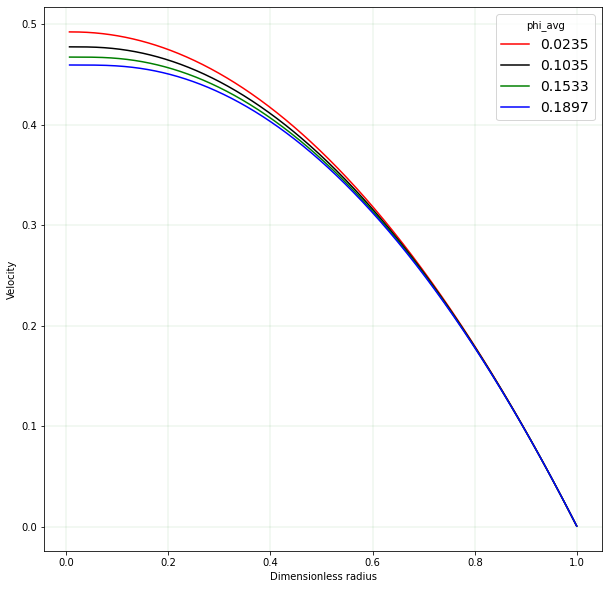

In [ ]:
fig = figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.grid(visible=True, which='both', axis='both', color='g', linestyle='-', linewidth=0.1)

colors = ['r', 'k', 'g', 'b', 'm', 'y', 'c']
for i in range(len(phi_avg_values)):
  ax.plot(diff_r[i][1:-1], diff_u[i][1:-1], '-', markevery=20, color=colors[i], label=f"{phi_avg_values[i]}")
ax.set_xlabel('Dimensionless radius')
ax.set_ylabel('Velocity')
ax.legend(loc='best', title='phi_avg', prop={'size':14})

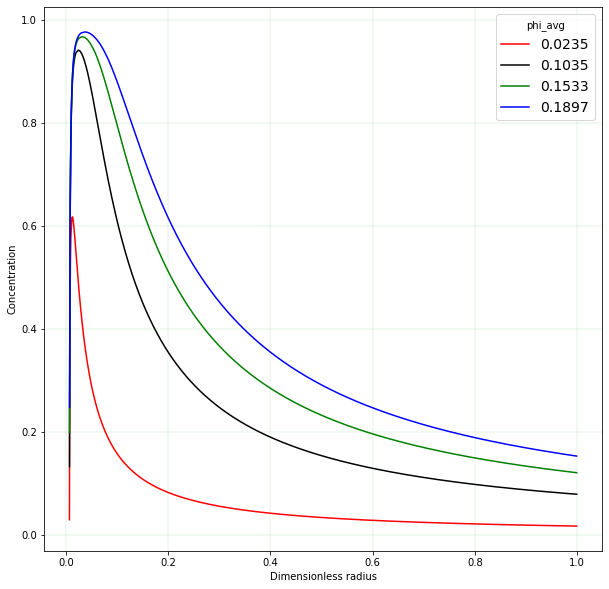

In [ ]:
fig = figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.grid(visible=True, which='both', axis='both', color='g', linestyle='-', linewidth=0.1)
colors = ['r', 'k', 'g', 'b', 'm', 'y', 'c']
for i in range(len(phi_avg_values)):
  ax.plot(diff_r[i][1:-1], diff_phi[i][1:-1]/0.719, '-', markevery=20, color=colors[i], label=f"{phi_avg_values[i]}")
ax.set_xlabel('Dimensionless radius')
ax.set_ylabel('Concentration')
ax.legend(loc='best', title='phi_avg', prop={'size':14})
show()

# Template code lines for quality plotting - related to research paper

In [ ]:
#initiate the fig object
fig = figure(figsize=(6,6))

# ax is the main plot
ax = fig.add_subplot(111)

# set the title if needed
ax.set_title('some title name', fontsize=15)

# name the axis labels
ax.set_xlabel('some label of x axis', fontsize=16)
ax.set_ylabel('some label of y axis', fontsize=16)

# single line plot (lw is linewidth, ls is linestyle)
ax.plot('some x axis array', 'some y axis array', ls='--', lw=1, label= 'some label for the line', color='k')

# multiple line plot without for loop
ax.plot(x1, y1, ls='-.', lw=1, label= 'some label for the line 1', color='k')
ax.plot(x2, y2, ls='--', lw=1, label= 'some label for the line 2', color='r')
ax.plot(x3, y3, ls=':', lw=1, label= 'some label for the line 3', color='b')

# multiple line plot with for loop
arrays_x = [x1, x2, x3]
arrays_y = [y1, y2, y3]
linestyles = ['-.', '--', ':']
labels = ['some label for the line 1', 'some label for the line 2', 'some label for the line 3']
colors = ['k', 'r', 'b']

for x, y, s, l, c in zip(arrays_x, arrays_y, linestyles, labels, colors):
    ax.plot(x, y, ls=s, lw=1, label=l, color=c)

# add legend if needed
ax.legend(loc='best', title='some title', prop={'size':14})
# adjust legend title fontsize
ax.get_legend().get_title().set_fontsize('16')

# or use custom legend if needed
custom_lines = [Line2D([0], [0], color='k', label= 'some name 1'),
                Line2D([0], [0], linestyle='dashed', color='magenta', label='some name 2')]
ax.legend(handles=custom_lines, loc='best', title='some title', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')

# if you want to add labels on top of the curves (align = True if you want them to be in horizontal position. xvals are used to position the labels corresponding to x axis values)
labelLines(ax.get_lines(), zorder=2.5, fontsize=14, align=False, color = 'k', xvals=[0.1, 0.2])

# x or y axis limits if needed
ax.set_xlim([0, 1])
ax.set_ylim([0, 0.7])

# or another way to do this
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=0.7)

# some decorations with ticks and margins
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0) #use value between 0 to 1 to use margins on the corners of the plot

# decimal points for labels if needed (2 decimal places in this example.)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# use this code lines to make the labels in scientific notation instead of decimal places
ax4.ticklabel_format(style='sci', axis='x', scilimits=(5,5))

# to save the figure in eps good quality format
fig.savefig("some name" + '.eps', format='eps')

Example of how plot

In [ ]:
model1 = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.4, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
model2 = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.2, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})

model1.solver(1000)
model2.solver(1000)

x1 = model1.r
y1 = model1.u
x2 = model2.r
y2 = model2.u

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


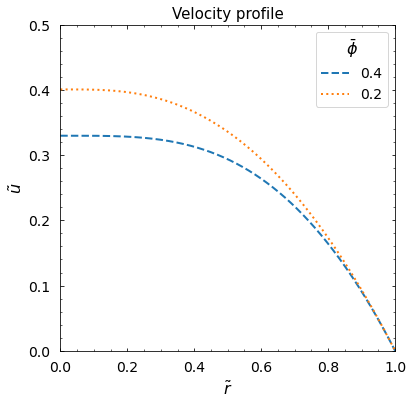

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title('Velocity profile', fontsize=15)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$\\tilde{u}$', fontsize=16)
ax.plot(x1, y1, ls='--', lw=2, label= '0.4')
ax.plot(x2, y2, ls=':', lw=2, label= '0.2')
ax.legend(loc='best', title='$\\bar{\phi}$', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 1])
ax.set_ylim([0, 0.5])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("velocity profile for different average particle colume fraction" + '.eps', format='eps')

In [ ]:
# Analytical solution by Phillips et al.
def phillips_analytic(r, phiw):
    phim = 0.68
    return phim/(1+((phim-phiw)/phiw)*r)

def newt(s, gamma_dot_w):
    return 1

fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)

r = np.linspace(0, 1, 100)
phibar = [0.4, 0.5, 0.6]
for v in phibar:
    model = particle_solve(radius=0.01, alpha = 0.645390070921986, dpdz = 1E4, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': newt})
    model.solver(1500)

    ax.plot(r, phillips_analytic(r, model.phiw), color='k', label='$\\bar{\phi}$=' + '{:.1f}'.format(v))
    ax.plot(model.r[1:], model.phi[1:], '-.', lw=1.1, markerfacecolor='None', color='magenta')

custom_lines = [Line2D([0], [0], color='k', label='Phillips et al. (1992)'),
                Line2D([0], [0], linestyle='-.', color='magenta', label='Present work')]

ax.legend(handles = custom_lines, fontsize=14, title='Analytical solution', loc='lower left')

labelLines(ax.get_lines(), zorder=2.5, fontsize=16, align=False, color = 'k')
ax.set_xlabel("$\\tilde{r}$", fontsize=16)
ax.set_ylabel("$\phi$", fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim([0.2, 0.7])
ax.margins(0)
ax.get_legend().get_title().set_fontsize('16')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
fig.savefig("analytic" + '.eps', format='eps')

Influence of parameters section: Average particle volume fraction

Figure a

In [ ]:
def Carreau_Yasuda(s, gamma_dot_w):
    eta_i = 100
    eta_0 = 1400
    a_cy = 1.25
    lmbd = 1.6
    n = 0.5
    return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)

def KD(phi):
    phi_m = 0.68
    return (1-phi/phi_m)**(-1.82)

phi_bar = [0.1, 0.2, 0.3, 0.4]

phi = []
r = []

for v in phi_bar:
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    phi.append(model.phi)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


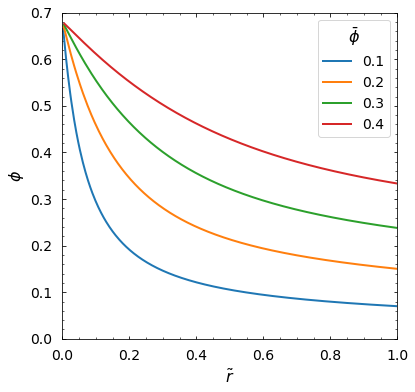

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$\phi$', fontsize=16)

for i in range(4):
    ax.plot(r[i][1:], phi[i][1:], ls='-', lw=2, label= '%.1f'%(phi_bar[i]))
ax.legend(loc='best', title='$\\bar{\phi}$', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 1])
ax.set_ylim([0, 0.7])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("phi_effects_a" + '.eps', format='eps')

Figure b

In [ ]:
phi_bar = np.linspace(0.05, 0.45, 15)
phi_w = []

for v in phi_bar:
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    phi_w.append(model.phiw)

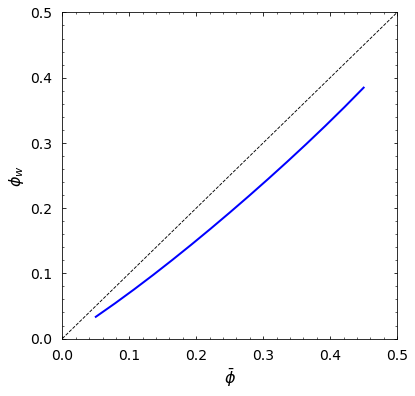

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\bar{\phi}$', fontsize=16)
ax.set_ylabel('$\phi_w$', fontsize=16)

ax.plot(phi_bar, phi_w, ls='-', lw=2, color='blue')
ax.plot([0, 0.5], [0, 0.5], ls = '--', color = 'k', lw = 0.9)
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 0.5])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("phi_effects_b" + '.eps', format='eps')

Figure c

In [ ]:
phi_bar = [0.1, 0.2, 0.3, 0.4]

u = []
r = []

for v in phi_bar:
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u.append(model.u*model.R*model.srw*100)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


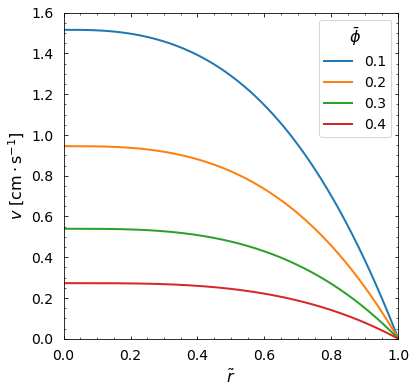

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$v$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=16)

for i in range(4):
    ax.plot(r[i], u[i], ls='-', lw=2, label= '%.1f'%(phi_bar[i]))
ax.legend(loc='best', title='$\\bar{\phi}$', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.6])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("phi_effects_c" + '.eps', format='eps')

Figure d

In [ ]:
phi_bar = np.linspace(0.1, 0.4, 12)
u_avg = []

for v in phi_bar:
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u_avg.append(model.u_avg*model.R*model.srw*100)

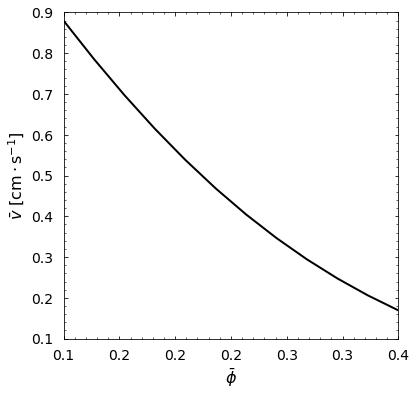

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\bar{\phi}$', fontsize=16)
ax.set_ylabel('$\\bar{v}$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=16)

ax.plot(phi_bar, u_avg, ls='-', lw=2, color='k')
ax.set_xlim([0.1, 0.4])
ax.set_ylim([0.1, 0.9])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("phi_effects_d" + '.eps', format='eps')

Pressure drop influence

Figure a

In [ ]:
def Carreau_Yasuda(s, gamma_dot_w):
    eta_i = 100
    eta_0 = 1400
    a_cy = 1.25
    lmbd = 1.6
    n = 0.5
    return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)

def KD(phi):
    phi_m = 0.68
    return (1-phi/phi_m)**(-1.82)

dpdz = [0.2E6, 0.6E6, 1E6, 1.4E6]

phi = []
r = []

for v in dpdz:
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = v, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    phi.append(model.phi)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


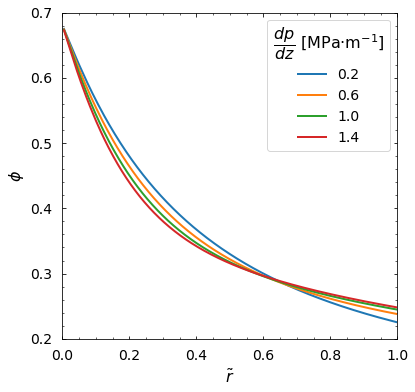

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$\phi$', fontsize=16)

for i in range(4):
    ax.plot(r[i][1:], phi[i][1:], ls='-', lw=2, label= '%.1f'%(dpdz[i]/1000000))
ax.legend(loc='best', title='$\\dfrac{dp}{dz}$ [MPa$\cdot \mathrm{m}^{-1}$]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 1])
ax.set_ylim([0.2, 0.7])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("dpdz_effects_a" + '.eps', format='eps')

Figure b

In [ ]:
phi_bar = np.linspace(0.05, 0.45, 15)
phi_w_arr = []

for d in dpdz:
    phi_w = []
    for v in phi_bar:
        model = particle_solve(radius=0.01, alpha = 0.66, dpdz = d, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
        model.solver(1000)
        phi_w.append(model.phiw)
    phi_w_arr.append(phi_w)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


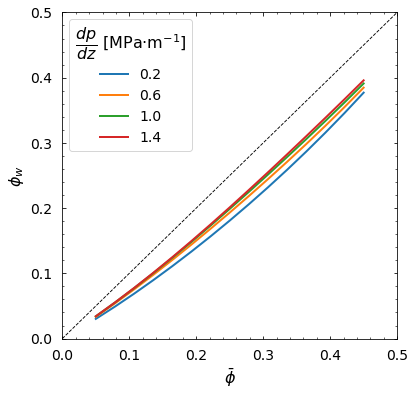

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\bar{\phi}$', fontsize=16)
ax.set_ylabel('$\phi_w$', fontsize=16)

for i, y in enumerate(phi_w_arr):
    ax.plot(phi_bar, y, ls='-', lw=2, label='%.1f'%(dpdz[i]/1000000))
ax.plot([0, 0.5], [0, 0.5], ls = '--', color = 'k', lw = 0.9)
ax.legend(loc='best', title='$\\dfrac{dp}{dz}$ [MPa$\cdot \mathrm{m}^{-1}$]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 0.5])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("dpdz_effects_b" + '.eps', format='eps')

Figure c

In [ ]:
u = []
r = []

for v in dpdz:
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = v, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u.append(model.u*model.R*model.srw*100)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


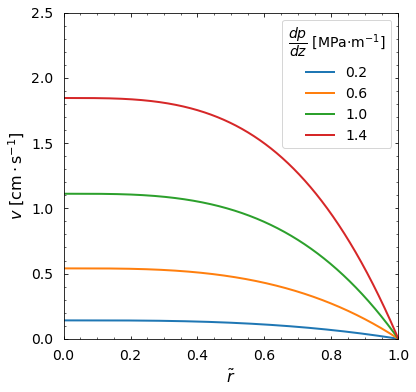

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$v$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=16)

for i in range(4):
    ax.plot(r[i], u[i], ls='-', lw=2, label= '%.1f'%(dpdz[i]/1000000))
ax.legend(loc='best', title='$\\dfrac{dp}{dz}$ [MPa$\cdot \mathrm{m}^{-1}$]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('14')
ax.set_xlim([0, 1])
ax.set_ylim([0, 2.5])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("dpdz_effects_c" + '.eps', format='eps')

In [ ]:
dpdz = np.linspace(0.2E6, 1.4E6, 12)
u_avg = []

for v in dpdz:
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = v, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u_avg.append(model.u_avg*model.R*model.srw*100)

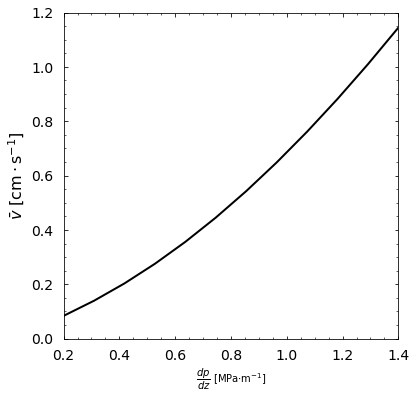

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\dfrac{dp}{dz}$ [MPa$\cdot \mathrm{m}^{-1}$]', fontsize=10)
ax.set_ylabel('$\\bar{v}$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=16)

ax.plot(dpdz/1000000, u_avg, ls='-', lw=2, color='k')
# ax.set_xlim([0.2, 1.4])
ax.set_ylim([0, 1.2])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("dpdz_effects_d" + '.eps', format='eps')

Influence of eta_inf
Figure a

In [ ]:
def KD(phi):
    phi_m = 0.68
    return (1-phi/phi_m)**(-1.82)

eta_inf = [100, 300, 500, 700]

phi = []
r = []

for v in eta_inf:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = v
        eta_0 = 1400
        a_cy = 1.25
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    phi.append(model.phi)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


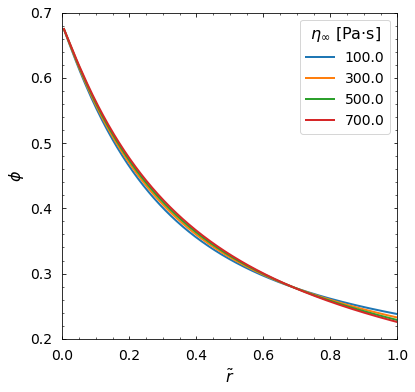

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$\phi$', fontsize=16)

for i in range(4):
    ax.plot(r[i][1:], phi[i][1:], ls='-', lw=2, label= '%.1f'%(eta_inf[i]))
ax.legend(loc='best', title='$\eta_{\infty}$ [Pa$\cdot \mathrm{s}$]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 1])
ax.set_ylim([0.2, 0.7])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("eta_i_effects_a" + '.eps', format='eps')

Figure b

In [ ]:
phi_bar = np.linspace(0.05, 0.45, 12)
phi_w_arr = []

for d in eta_inf:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = d
        eta_0 = 1400
        a_cy = 1.25
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    phi_w = []
    for v in phi_bar:
        model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
        model.solver(1000)
        phi_w.append(model.phiw)
    phi_w_arr.append(phi_w)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


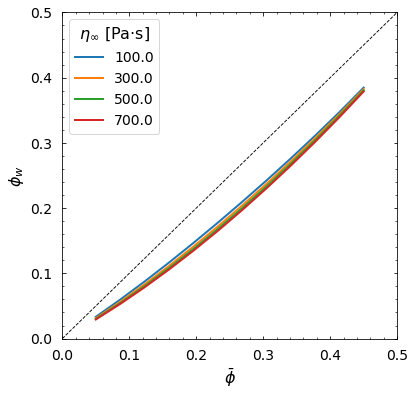

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\bar{\phi}$', fontsize=16)
ax.set_ylabel('$\phi_w$', fontsize=16)

for i, y in enumerate(phi_w_arr):
    ax.plot(phi_bar, y, ls='-', lw=2, label='%.1f'%(eta_inf[i]))
ax.plot([0, 0.5], [0, 0.5], ls = '--', color = 'k', lw = 0.9)
ax.legend(loc='best', title='$\eta_{\infty}$ [Pa$\cdot \mathrm{s}$]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 0.5])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("eta_i_effects_b" + '.eps', format='eps')

Figure c

In [ ]:
u = []
r = []

for v in eta_inf:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = v
        eta_0 = 1400
        a_cy = 1.25
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u.append(model.u*model.R*model.srw*100)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


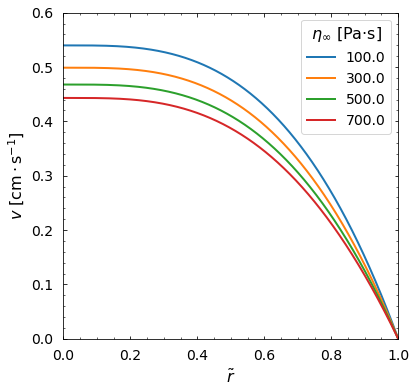

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$v$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=16)

for i in range(4):
    ax.plot(r[i], u[i], ls='-', lw=2, label= '%.1f'%(eta_inf[i]))
ax.legend(loc='best', title='$\eta_{\infty}$ [Pa$\cdot \mathrm{s}$]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 1])
ax.set_ylim([0, 0.6])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("eta_i_effects_c" + '.eps', format='eps')

Figure d

In [ ]:
eta_inf = np.linspace(100, 700, 12)
u_avg = []

for v in eta_inf:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = v
        eta_0 = 1400
        a_cy = 1.25
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u_avg.append(model.u_avg*model.R*model.srw*100)

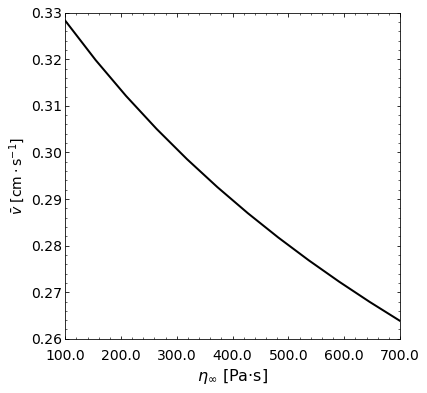

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\eta_{\infty}$ [Pa$\cdot \mathrm{s}$]', fontsize=16)
ax.set_ylabel('$\\bar{v}$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=14)

ax.plot(eta_inf, u_avg, ls='-', lw=2, color='k')
# ax.set_xlim([0.2, 1.4])
ax.set_ylim([0.26, 0.33])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=3)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.savefig("eta_i_effects_d" + '.eps', format='eps')

Influence of eta_0: Figure a

In [ ]:
def KD(phi):
    phi_m = 0.68
    return (1-phi/phi_m)**(-1.82)

eta_0 = [1000, 3000, 5000, 7000]

phi = []
r = []

for v in eta_0:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = v
        a_cy = 1.25
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    phi.append(model.phi)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


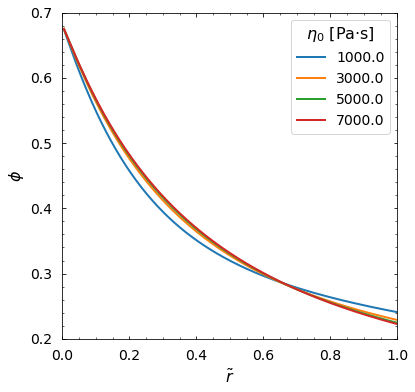

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$\phi$', fontsize=16)

for i in range(4):
    ax.plot(r[i][1:], phi[i][1:], ls='-', lw=2, label= '%.1f'%(eta_0[i]))
ax.legend(loc='best', title='$\eta_{0}$ [Pa$\cdot \mathrm{s}$]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 1])
ax.set_ylim([0.2, 0.7])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("eta_0_effects_a" + '.eps', format='eps')

Figure b

In [ ]:
phi_bar = np.linspace(0.05, 0.45, 12)
phi_w_arr = []

for d in eta_0:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = d
        a_cy = 1.25
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    phi_w = []
    for v in phi_bar:
        model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
        model.solver(1000)
        phi_w.append(model.phiw)
    phi_w_arr.append(phi_w)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


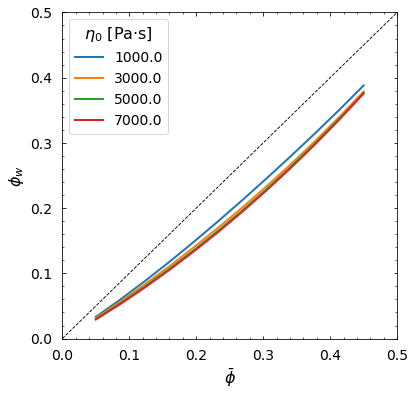

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\bar{\phi}$', fontsize=16)
ax.set_ylabel('$\phi_w$', fontsize=16)

for i, y in enumerate(phi_w_arr):
    ax.plot(phi_bar, y, ls='-', lw=2, label='%.1f'%(eta_0[i]))
ax.plot([0, 0.5], [0, 0.5], ls = '--', color = 'k', lw = 0.9)
ax.legend(loc='best', title='$\eta_{0}$ [Pa$\cdot \mathrm{s}$]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 0.5])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("eta_0_effects_b" + '.eps', format='eps')

Figure c

In [ ]:
u = []
r = []

for v in eta_0:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = v
        a_cy = 1.25
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u.append(model.u*model.R*model.srw*100)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


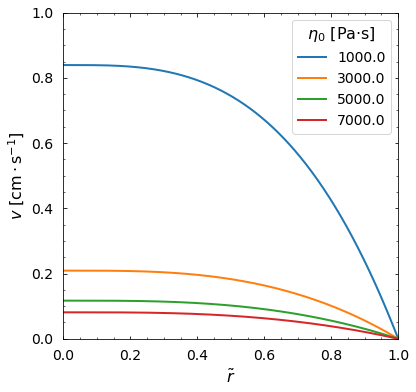

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$v$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=16)

for i in range(4):
    ax.plot(r[i], u[i], ls='-', lw=2, label= '%.1f'%(eta_0[i]))
ax.legend(loc='best', title='$\eta_{0}$ [Pa$\cdot \mathrm{s}$]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
# ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("eta_0_effects_c" + '.eps', format='eps')

Figure d

In [ ]:
eta_0 = np.linspace(1000, 7000, 10)
u_avg = []

for v in eta_0:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = v
        a_cy = 1.25
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u_avg.append(model.u_avg*model.R*model.srw*100)

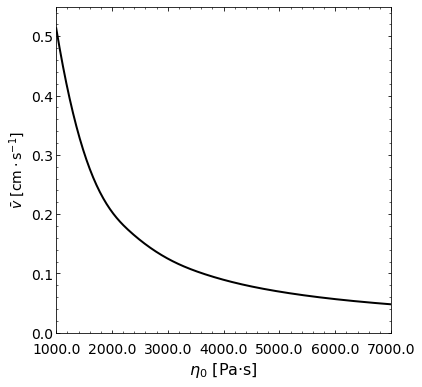

In [ ]:
from scipy.interpolate import make_interp_spline
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\eta_{0}$ [Pa$\cdot \mathrm{s}$]', fontsize=16)
ax.set_ylabel('$\\bar{v}$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=14)

eta_0_new = np.linspace(eta_0.min(), eta_0.max(), 300)
spl = make_interp_spline(eta_0, u_avg, k=3)
power_smooth = spl(eta_0_new)

ax.plot(eta_0_new, power_smooth, ls='-', lw=2, color='k')
# ax.set_xlim([0.2, 1.4])
ax.set_ylim([0, 0.55])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=3)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("eta_0_effects_d" + '.eps', format='eps')

Influence of a: Figure a

In [ ]:
def KD(phi):
    phi_m = 0.68
    return (1-phi/phi_m)**(-1.82)

a = [1.25, 1.5, 1.75, 2]

phi = []
r = []

for v in a:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = v
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    phi.append(model.phi)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


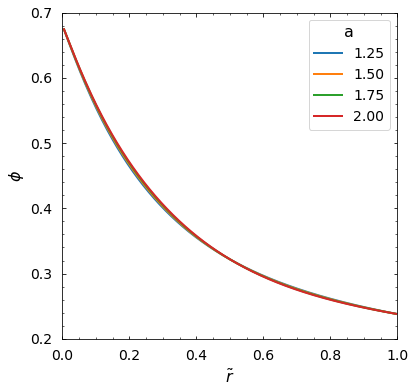

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$\phi$', fontsize=16)

for i in range(4):
    ax.plot(r[i][1:], phi[i][1:], ls='-', lw=2, label= '%.2f'%(a[i]))
ax.legend(loc='best', title='a', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 1])
ax.set_ylim([0.2, 0.7])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("a_effects_a" + '.eps', format='eps')

Figure b

In [ ]:
phi_bar = np.linspace(0.05, 0.45, 12)
phi_w_arr = []

for d in a:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = d
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    phi_w = []
    for v in phi_bar:
        model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
        model.solver(1000)
        phi_w.append(model.phiw)
    phi_w_arr.append(phi_w)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


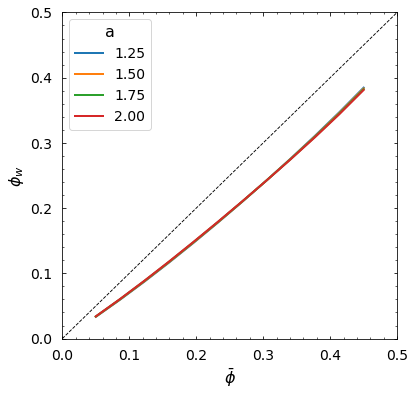

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\bar{\phi}$', fontsize=16)
ax.set_ylabel('$\phi_w$', fontsize=16)

for i, y in enumerate(phi_w_arr):
    ax.plot(phi_bar, y, ls='-', lw=2, label='%.2f'%(a[i]))
ax.plot([0, 0.5], [0, 0.5], ls = '--', color = 'k', lw = 0.9)
ax.legend(loc='best', title='a', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 0.5])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("a_effects_b" + '.eps', format='eps')

Figure c

In [ ]:
u = []
r = []

for v in a:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = v
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u.append(model.u*model.R*model.srw*100)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


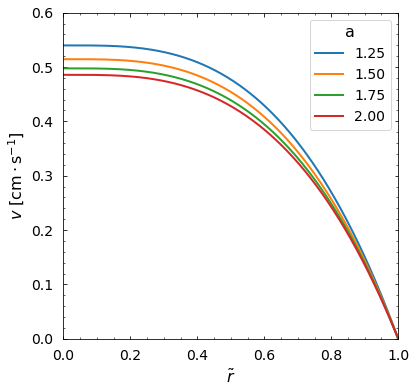

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$v$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=16)

for i in range(4):
    ax.plot(r[i], u[i], ls='-', lw=2, label= '%.2f'%(a[i]))
ax.legend(loc='best', title='a', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
# ax.set_xlim([0, 1])
ax.set_ylim([0, 0.6])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("a_effects_c" + '.eps', format='eps')

Figure d

In [ ]:
a = np.linspace(1.25, 2, 10)
u_avg = []

for v in a:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = v
        lmbd = 1.6
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u_avg.append(model.u_avg*model.R*model.srw*100)

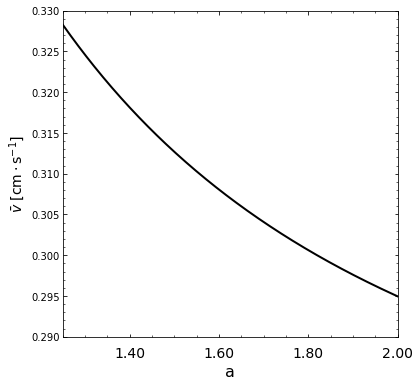

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('a', fontsize=16)
ax.set_ylabel('$\\bar{v}$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=14)

a_new = np.linspace(a.min(), a.max(), 300)
spl = make_interp_spline(a, u_avg, k=3)
power_smooth = spl(a_new)

ax.plot(a_new, power_smooth, ls='-', lw=2, color='k')
ax.set_xlim([1.25, 2])
ax.set_ylim([0.29, 0.33])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 10, pad=3)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
fig.savefig("a_effects_d" + '.eps', format='eps')

Influence of $\lambda$: Figure a

In [ ]:
def KD(phi):
    phi_m = 0.68
    return (1-phi/phi_m)**(-1.82)

lm = [1.2, 2.5, 3.5, 5]

phi = []
r = []

for v in lm:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = 1.25
        lmbd = v
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    phi.append(model.phi)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


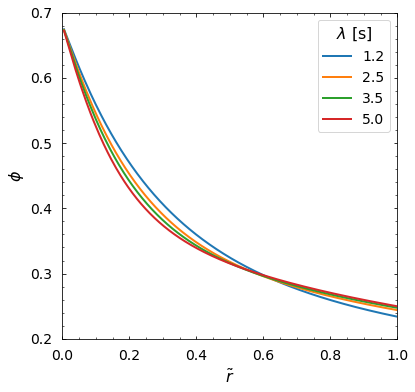

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$\phi$', fontsize=16)

for i in range(4):
    ax.plot(r[i][1:], phi[i][1:], ls='-', lw=2, label= '%.1f'%(lm[i]))
ax.legend(loc='best', title='$\lambda$ [s]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 1])
ax.set_ylim([0.2, 0.7])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("lmbd_effects_a" + '.eps', format='eps')

Figure b

In [ ]:
phi_bar = np.linspace(0.05, 0.45, 12)
phi_w_arr = []

for d in lm:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = 1.25
        lmbd = d
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    phi_w = []
    for v in phi_bar:
        model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
        model.solver(1000)
        phi_w.append(model.phiw)
    phi_w_arr.append(phi_w)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


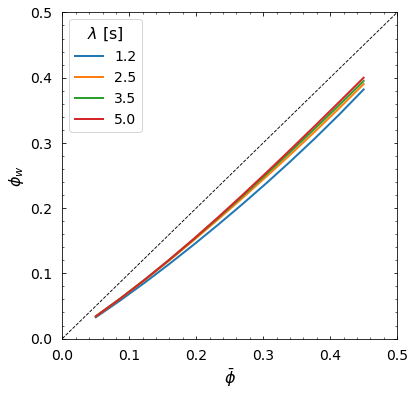

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\bar{\phi}$', fontsize=16)
ax.set_ylabel('$\phi_w$', fontsize=16)

for i, y in enumerate(phi_w_arr):
    ax.plot(phi_bar, y, ls='-', lw=2, label='%.1f'%(lm[i]))
ax.plot([0, 0.5], [0, 0.5], ls = '--', color = 'k', lw = 0.9)
ax.legend(loc='best', title='$\lambda$ [s]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 0.5])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("lmbd_effects_b" + '.eps', format='eps')

Figure c

In [ ]:
u = []
r = []

for v in lm:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = 1.25
        lmbd = v
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u.append(model.u*model.R*model.srw*100)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


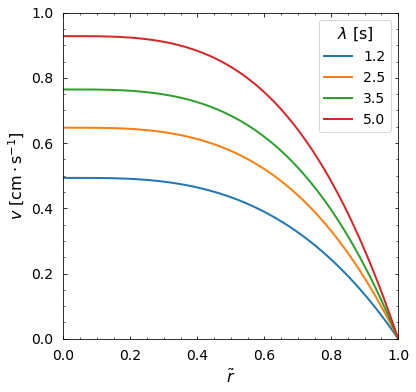

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$v$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=16)

for i in range(4):
    ax.plot(r[i], u[i], ls='-', lw=2, label= '%.1f'%(lm[i]))
ax.legend(loc='best', title='$\lambda$ [s]', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
# ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("lmbd_effects_c" + '.eps', format='eps')

Figure d

In [ ]:
lm = np.linspace(1.2, 5, 10)
u_avg = []

for v in lm:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = 1.25
        lmbd = v
        n = 0.5
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u_avg.append(model.u_avg*model.R*model.srw*100)

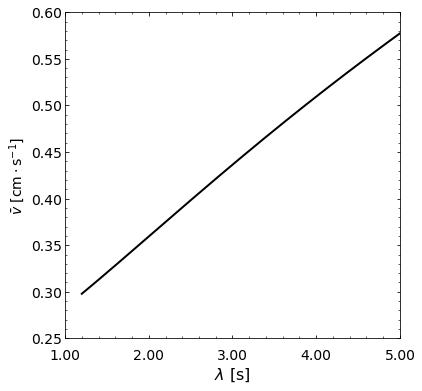

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\lambda$ [s]', fontsize=16)
ax.set_ylabel('$\\bar{v}$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=14)

lm_new = np.linspace(lm.min(), lm.max(), 300)
spl = make_interp_spline(lm, u_avg, k=3)
power_smooth = spl(lm_new)

ax.plot(lm_new, power_smooth, ls='-', lw=2, color='k')
ax.set_xlim([1, 5])
# ax.set_ylim([0.25, 0.6])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=3)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.savefig("lmbd_effects_d" + '.eps', format='eps')

Influence of $n$: Figure a

In [ ]:
def KD(phi):
    phi_m = 0.68
    return (1-phi/phi_m)**(-1.82)

n = [0.1, 0.4, 0.7, 1]

phi = []
r = []

for v in n:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = 1.25
        lmbd = 1.6
        n = v
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    phi.append(model.phi)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


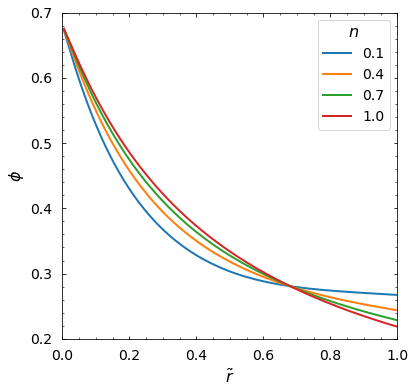

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$\phi$', fontsize=16)

for i in range(4):
    ax.plot(r[i][1:], phi[i][1:], ls='-', lw=2, label= '%.1f'%(n[i]))
ax.legend(loc='best', title='$n$', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 1])
ax.set_ylim([0.2, 0.7])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("n_effects_a" + '.eps', format='eps')

Figure b

In [ ]:
phi_bar = np.linspace(0.05, 0.45, 12)
phi_w_arr = []

for d in n:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = 1.25
        lmbd = 1.6
        n = d
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    phi_w = []
    for v in phi_bar:
        model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
        model.solver(1000)
        phi_w.append(model.phiw)
    phi_w_arr.append(phi_w)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


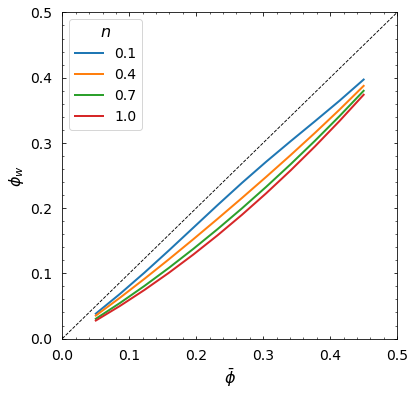

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\bar{\phi}$', fontsize=16)
ax.set_ylabel('$\phi_w$', fontsize=16)

for i, y in enumerate(phi_w_arr):
    ax.plot(phi_bar, y, ls='-', lw=2, label='%.1f'%(n[i]))
ax.plot([0, 0.5], [0, 0.5], ls = '--', color = 'k', lw = 0.9)
ax.legend(loc='best', title='$n$', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 0.5])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("n_effects_b" + '.eps', format='eps')

Figure c

In [ ]:
u = []
r = []

for v in n:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = 1.25
        lmbd = 1.6
        n = v
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u.append(model.u*model.R*model.srw*100)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


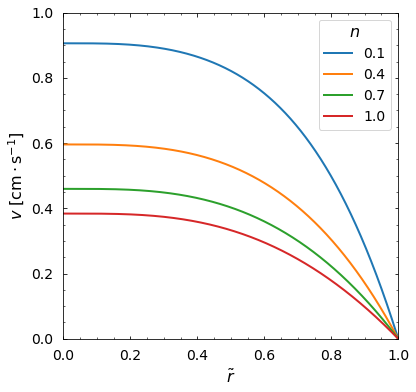

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$v$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=16)

for i in range(4):
    ax.plot(r[i], u[i], ls='-', lw=2, label= '%.1f'%(n[i]))
ax.legend(loc='best', title='$n$', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
# ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("n_effects_c" + '.eps', format='eps')

Figure d

In [ ]:
n = np.linspace(0.1, 1, 10)
u_avg = []

for v in n:
    def Carreau_Yasuda(s, gamma_dot_w):
        eta_i = 100
        eta_0 = 1400
        a_cy = 1.25
        lmbd = 1.6
        n = v
        return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)
    model = particle_solve(radius=0.01, alpha = 0.66, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u_avg.append(model.u_avg*model.R*model.srw*100)

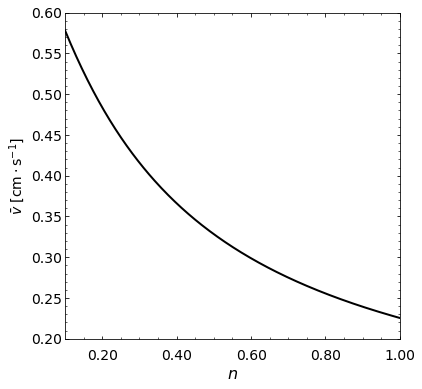

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$n$', fontsize=16)
ax.set_ylabel('$\\bar{v}$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=14)

n_new = np.linspace(n.min(), n.max(), 300)
spl = make_interp_spline(n, u_avg, k=3)
power_smooth = spl(n_new)

ax.plot(n_new, power_smooth, ls='-', lw=2, color='k')
# ax.set_xlim([1, 5])
ax.set_ylim([0.2, 0.6])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=3)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.savefig("n_effects_d" + '.eps', format='eps')

Influence of $\alpha$: Figure a

In [ ]:
def KD(phi):
    phi_m = 0.68
    return (1-phi/phi_m)**(-1.82)

def Carreau_Yasuda(s, gamma_dot_w):
    eta_i = 100
    eta_0 = 1400
    a_cy = 1.25
    lmbd = 1.6
    n = 0.5
    return eta_i + (eta_0 - eta_i)*(1+(lmbd*gamma_dot_w*s)**a_cy)**((n-1)/a_cy)

alph = [0.4, 0.6, 0.8, 0.95]

phi = []
r = []

for v in alph:

    model = particle_solve(radius=0.01, alpha = v, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    phi.append(model.phi)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


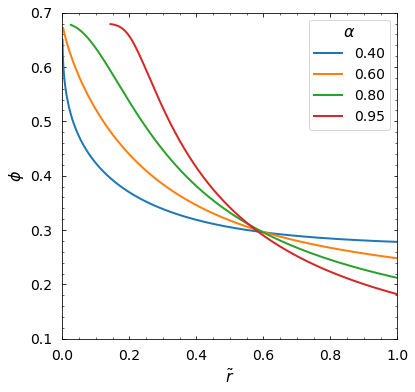

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$\phi$', fontsize=16)

for i in range(4):
    ax.plot(r[i][1:], phi[i][1:], ls='-', lw=2, label= '%.2f'%(alph[i]))
ax.legend(loc='best', title='$\\alpha$', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 1])
ax.set_ylim([0.1, 0.7])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("alpha_effects_a" + '.eps', format='eps')

Figure b

In [ ]:
phi_bar = np.linspace(0.05, 0.45, 12)
phi_w_arr = []

for d in alph:
    phi_w = []
    for v in phi_bar:
        model = particle_solve(radius=0.01, alpha = d, dpdz = 0.6E6, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
        model.solver(500)
        phi_w.append(model.phiw)
    phi_w_arr.append(phi_w)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


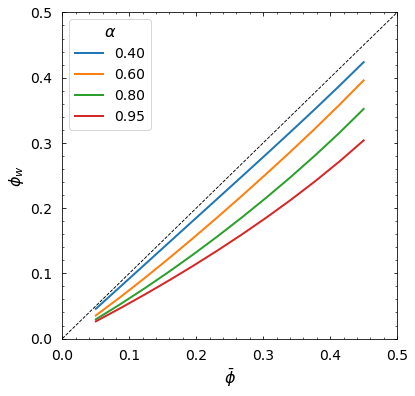

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\bar{\phi}$', fontsize=16)
ax.set_ylabel('$\phi_w$', fontsize=16)

for i, y in enumerate(phi_w_arr):
    ax.plot(phi_bar, y, ls='-', lw=2, label='%.2f'%(alph[i]))
ax.plot([0, 0.5], [0, 0.5], ls = '--', color = 'k', lw = 0.9)
ax.legend(loc='best', title='$\\alpha$', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 0.5])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("alpha_effects_b" + '.eps', format='eps')

Figure c

In [ ]:
u = []
r = []

for v in alph:
    model = particle_solve(radius=0.01, alpha = v, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u.append(model.u*model.R*model.srw*100)
    r.append(model.r)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


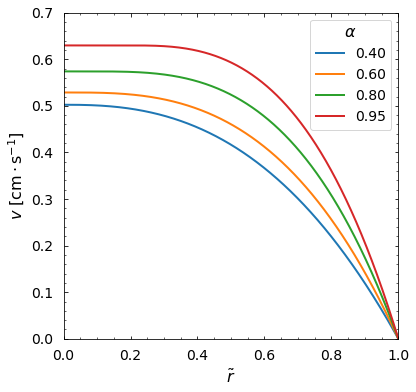

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\tilde{r}$', fontsize=16)
ax.set_ylabel('$v$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=16)

for i in range(4):
    ax.plot(r[i], u[i], ls='-', lw=2, label= '%.2f'%(alph[i]))
ax.legend(loc='best', title='$\\alpha$', prop={'size':14})
ax.get_legend().get_title().set_fontsize('16')
# ax.set_xlim([0, 1])
ax.set_ylim([0, 0.7])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=10)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("alpha_effects_c" + '.eps', format='eps')

Figure d

In [ ]:
alph = np.linspace(0.4, 0.95, 10)
u_avg = []

for v in alph:
    model = particle_solve(radius=0.01, alpha = v, dpdz = 0.6E6, phi_avg = 0.3, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': Carreau_Yasuda})
    model.solver(1000)
    u_avg.append(model.u_avg*model.R*model.srw*100)

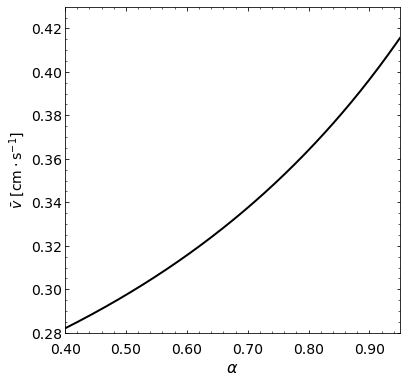

In [ ]:
fig = figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_xlabel('$\\alpha$', fontsize=16)
ax.set_ylabel('$\\bar{v}$ [$\mathrm{cm}\cdot\mathrm{s}^{-1}$]', fontsize=14)

alph_new = np.linspace(alph.min(), alph.max(), 300)
spl = make_interp_spline(alph, u_avg, k=3)
power_smooth = spl(alph_new)

ax.plot(alph_new, power_smooth, ls='-', lw=2, color='k')
# ax.set_xlim([1, 5])
ax.set_ylim([0.28, 0.43])
ax.tick_params(axis='x', which='both', bottom=True, top=True, direction='in', labelsize = 14, pad=10)
ax.tick_params(axis='y', which='both', left=True, right=True, direction='in', labelsize = 14, pad=3)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.margins(0)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.savefig("alpha_effects_d" + '.eps', format='eps')

Miscellanious code lines

$\dfrac{d\tilde{u}}{d\tilde{r}}$ = $-s$

Integration gives us the nondimensional velocity $\tilde{u}$

$\tilde{u}_i$=$\int_{\tilde{r}_i}^R sd\tilde{r}$

We want to validate our numerical algoirthm since $\tilde{r}$ is not evenly spaced

In [ ]:
model = particle_solve(radius=0.01, alpha = 0.645390070921986, dpdz = 1E4, phi_avg = v, power_law=False, sep=True, options = {'eta_r': KD, 'eta_s': newt})
model.solver(1000)

r, s, u = model.r, model.s, model.u

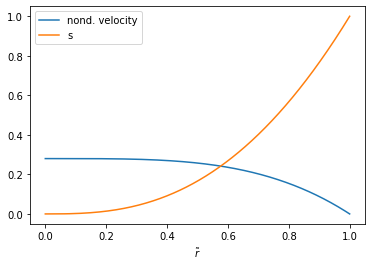

In [ ]:
plot(r, u, label = 'nond. velocity')
plot(r, s, label = 's')
xlabel('$\\tilde{r}$')
legend(loc='best')
show()

In [ ]:
def derivative(method, y, x):
    N = len(r)
    sh = np.zeros(N)
    if method=='backward':
        for i in range(1, N):
            dr = x[i]-x[i-1]
            sh[i] = (y[i]-y[i-1])/dr
        return -sh, method
    if method=='forward':
        for i in range(N-1, 1, -1):
            dr = x[i-1]-x[i]
            sh[i] = (y[i-1]-y[i])/dr
        return -sh, method

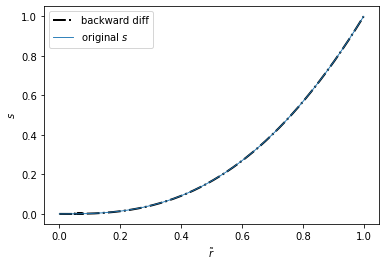

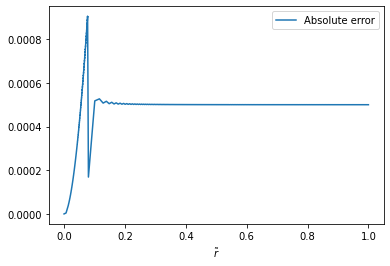

In [ ]:
sh, method = derivative('backward', u, r)
plot(r, sh, 'k-.', label = method + ' diff', lw=2)
plot(r, s, label = 'original $s$', lw = 0.9)
xlabel('$\\tilde{r}$')
ylabel('$s$')
legend(loc='best')
show()
plot(r, abs(s-sh), label = 'Absolute error')
xlabel('$\\tilde{r}$')
legend(loc='best')
show()

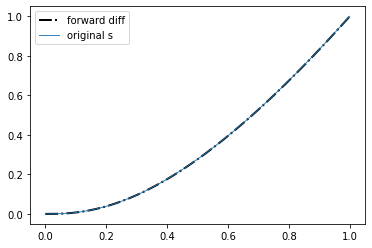

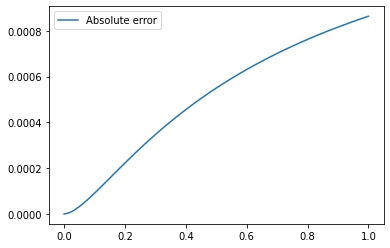

In [ ]:
sh, method = derivative('forward', u, r)
plot(r, sh, 'k-.', label = method + ' diff', lw=2)
plot(r, s, label = 'original s', lw = 0.9)
legend(loc='best')
show()
plot(r, abs(s-sh), label = 'Absolute error')
legend(loc='best')
show()